In [86]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import numpy as np
import lightgbm as lgbm
import os
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import time
import pickle

from tqdm import tqdm

from utils import load_json
from df_utils import form_last_quarter_df, form_pred_df
from features import QuarterlyFeatureCalculator
from data import load_quarterly_data_cf1, load_cf1_df, translate_currency_cf1
from models import QuarterlyOOFModel
sns.set()

config = load_json("config.json")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
tickers_df = pd.read_csv('{}/cf1/tickers.csv'.format(config['data_path']))
tickers_df = tickers_df[tickers_df['currency']=='USD']
tickers_df = tickers_df[tickers_df['scalemarketcap'].apply(lambda x: x in ['4 - Mid', '5 - Large', '6 - Mega'])]
ticker_list = tickers_df['ticker'].unique().tolist()

In [88]:
columns = ['revenue', 'netinc', 'ncf', 'assets', 'ebitda', 'debt', 'fcf', 'gp', 'workingcapital',
          'cashneq', 'rnd', 'sgna', 'ncfx', 'divyield', 'currentratio', 'netinccmn']

feat_calculator = QuarterlyFeatureCalculator(columns=columns, max_back_quarter=10)
marketcap_model = QuarterlyOOFModel(lgbm.sklearn.LGBMRegressor(), fold_cnt=5)


In [89]:
X = feat_calculator.calc_feats(ticker_list)
X = X[X['marketcap']  >= 2e9]
X.index = range(len(X))

100%|██████████| 3874/3874 [00:00<00:00, 894507.77it/s]


In [90]:
marketcap_model.fit(X.drop(['ticker', 'marketcap', 'date'], axis=1),
          np.log(X['marketcap']), X['ticker'])

In [91]:
pred = marketcap_model.predict(X.drop(['ticker', 'marketcap', 'date'], axis=1), X['ticker'])
pred = np.exp(pred)

In [99]:
with open('models_data/marketcap_model_.pickle', 'wb') as f:
    pickle.dump(marketcap_model, f)
    
with open('models_data/feat_calculator_.pickle', 'wb') as f:
    pickle.dump(feat_calculator, f)


In [92]:
imp_df = pd.DataFrame()
imp_df['column'] = X.drop(['ticker', 'marketcap', 'date'], axis=1).columns
imp_df['importance'] = marketcap_model.base_models[0].feature_importances_
imp_df = imp_df.sort_values('importance', ascending=False)[:]
imp_df[:10]

,column,importance
481,sicindustry,133
480,sector,49
455,quarter10_divyield_diff_mean,46
295,quarter4_divyield_diff_mean,39
201,quarter4_ebitda_median,37
459,quarter10_divyield_diff_std,32
407,quarter10_workingcapital_diff_max,31
130,quarter2_divyield_mean,31
471,quarter10_netinccmn_median,29
329,quarter10_revenue_diff_std,29


In [93]:
(np.abs(X['marketcap'] - pred) / X['marketcap']).mean()

0.3680506925378699

In [ ]:
0.3680506925378699

In [ ]:
0.359495615210965
0.36673398737875557
0.37584434057692745
mid-large cap

In [94]:
pred_df = form_pred_df(X, pred, tickers_df)
last_quarter_df = form_last_quarter_df(pred_df)

100%|██████████| 2079/2079 [00:04<00:00, 462.64it/s]


In [95]:
last_quarter_df

,ticker,date,marketcap,pred_marketcap,sector,exchange,sicindustry,ratio,last_marketcap,last_ratio,mean_ratio,ratio_ratio
0,AIV,2020-11-02,4.781574e+09,5.064064e+09,Real Estate,NYSE,Real Estate Investment Trusts,1.059079,5.807000e+08,8.720619,1.024291,8.513814
1,MESO,2020-09-03,2.082364e+09,3.140075e+09,Healthcare,NASDAQ,Biological Products (No Disgnostic Substances),1.507937,1.122400e+09,2.797643,1.507937,1.855278
2,MRK,2020-11-05,2.035666e+11,3.854684e+11,Healthcare,NYSE,Pharmaceutical Preparations,1.893574,1.898538e+11,2.030344,1.095165,1.853916
3,BLUE,2020-11-04,3.886158e+09,9.986633e+09,Healthcare,NASDAQ,Biological Products (No Disgnostic Substances),2.569796,3.178600e+09,3.141834,1.792835,1.752439
4,FLR,2020-12-10,2.566645e+09,5.062790e+09,Industrials,NYSE,Heavy Construction Other Than Bldg Const - Con...,1.972532,2.883300e+09,1.755901,1.026172,1.711117
...,...,...,...,...,...,...,...,...,...,...,...,...
1503,PLUG,2020-11-09,8.440801e+09,3.535195e+09,Industrials,NASDAQ,Electrical Industrial Apparatus,0.418822,2.733390e+10,0.129334,0.599760,0.215642
1504,SEDG,2020-11-04,1.056850e+10,5.682659e+09,Technology,NASDAQ,Semiconductors & Related Devices,0.537698,1.578540e+10,0.359995,1.747549,0.206000
1505,PENN,2020-11-04,9.277520e+09,6.670725e+09,Consumer Cyclical,NASDAQ,Hotels & Motels,0.719020,2.002290e+10,0.333155,2.199100,0.151496
1506,TSLA,2020-10-26,3.983837e+11,4.893113e+10,Consumer Cyclical,NASDAQ,Motor Vehicles & Passenger Car Bodies,0.122824,8.078294e+11,0.060571,0.488614,0.123965


In [96]:
last_quarter_df[last_quarter_df['ticker']=='PINC']

,ticker,date,marketcap,pred_marketcap,sector,exchange,sicindustry,ratio,last_marketcap,last_ratio,mean_ratio,ratio_ratio
520,PINC,2021-02-02,4.337030e+09,4.993250e+09,Technology,NASDAQ,Services-Management Services,1.151306,4.308900e+09,1.158822,1.298083,0.892718


In [76]:
last_quarter_df[last_quarter_df['ticker']=='YNDX']

,ticker,date,marketcap,pred_marketcap,sector,exchange,sicindustry,ratio,last_marketcap,last_ratio,mean_ratio,ratio_ratio
1413,YNDX,2020-10-28,2.097060e+10,9.103568e+10,Technology,NASDAQ,Services-Computer Programming Data Processing ...,4.34111,2.359500e+10,3.858261,7.973172,0.483905


In [77]:
X[X['ticker']=='YNDX']

,ticker,date,marketcap,quarter2_revenue_mean,quarter2_revenue_median,quarter2_revenue_max,quarter2_revenue_min,quarter2_revenue_std,quarter2_revenue_diff_mean,quarter2_revenue_diff_median,...,quarter10_netinccmn_max,quarter10_netinccmn_min,quarter10_netinccmn_std,quarter10_netinccmn_diff_mean,quarter10_netinccmn_diff_median,quarter10_netinccmn_diff_max,quarter10_netinccmn_diff_min,quarter10_netinccmn_diff_std,sector,sicindustry
3384,YNDX,2020-10-28,2.097060e+10,3.807098e+12,3.807098e+12,NaN,NaN,8.013669e+11,1.602734e+12,1.602734e+12,...,NaN,NaN,5.011957e+11,1.514051e+11,1.008059e+10,NaN,NaN,6.986410e+11,10,254
3385,YNDX,2020-07-28,1.995424e+10,3.120643e+12,3.120643e+12,NaN,NaN,1.149122e+11,-2.298243e+11,-2.298243e+11,...,NaN,NaN,2.020228e+11,-7.136757e+10,-1.483755e+10,NaN,NaN,2.566932e+11,10,254
3386,YNDX,2020-06-23,1.605643e+10,3.378903e+12,3.378903e+12,NaN,NaN,1.433473e+11,-2.866946e+11,-2.866946e+11,...,NaN,NaN,1.293069e+11,7.514117e+09,1.008059e+10,NaN,NaN,1.592517e+11,10,254
3387,YNDX,2020-04-28,1.231757e+10,3.679047e+12,3.679047e+12,NaN,NaN,1.567965e+11,-3.135930e+11,-3.135930e+11,...,NaN,NaN,5.730918e+11,-1.887750e+11,1.008059e+10,NaN,NaN,5.920986e+11,10,254
3388,YNDX,2020-04-02,1.075667e+10,3.561854e+12,3.561854e+12,NaN,NaN,2.739887e+11,5.479773e+11,5.479773e+11,...,NaN,NaN,5.807675e+11,-8.474411e+09,1.008059e+10,NaN,NaN,9.009172e+11,10,254
3389,YNDX,2020-02-14,1.536149e+10,3.087029e+12,3.087029e+12,NaN,NaN,2.008370e+11,4.016740e+11,4.016740e+11,...,NaN,NaN,5.739550e+11,-1.566972e+10,-1.483755e+10,NaN,NaN,9.009989e+11,10,254
3390,YNDX,2019-10-25,1.060024e+10,2.755543e+12,2.755543e+12,NaN,NaN,1.306490e+11,2.612981e+11,2.612981e+11,...,NaN,NaN,5.661821e+11,1.101693e+10,2.644684e+09,NaN,NaN,8.975827e+11,10,254
3391,YNDX,2019-07-26,1.210832e+10,2.501806e+12,2.501806e+12,NaN,NaN,1.230872e+11,2.461744e+11,2.461744e+11,...,NaN,NaN,5.777773e+11,2.033205e+10,2.644684e+09,NaN,NaN,8.985094e+11,10,254
3392,YNDX,2019-04-25,1.208841e+10,2.430218e+12,2.430218e+12,NaN,NaN,5.149891e+10,-1.029978e+11,-1.029978e+11,...,NaN,NaN,5.787102e+11,1.733477e+09,-1.483755e+10,NaN,NaN,9.002568e+11,10,254
3393,YNDX,2019-04-19,1.212531e+10,2.529276e+12,2.529276e+12,NaN,NaN,4.755902e+10,-9.511803e+10,-9.511803e+10,...,NaN,NaN,5.873834e+11,3.777556e+10,2.644684e+09,NaN,NaN,8.994563e+11,10,254


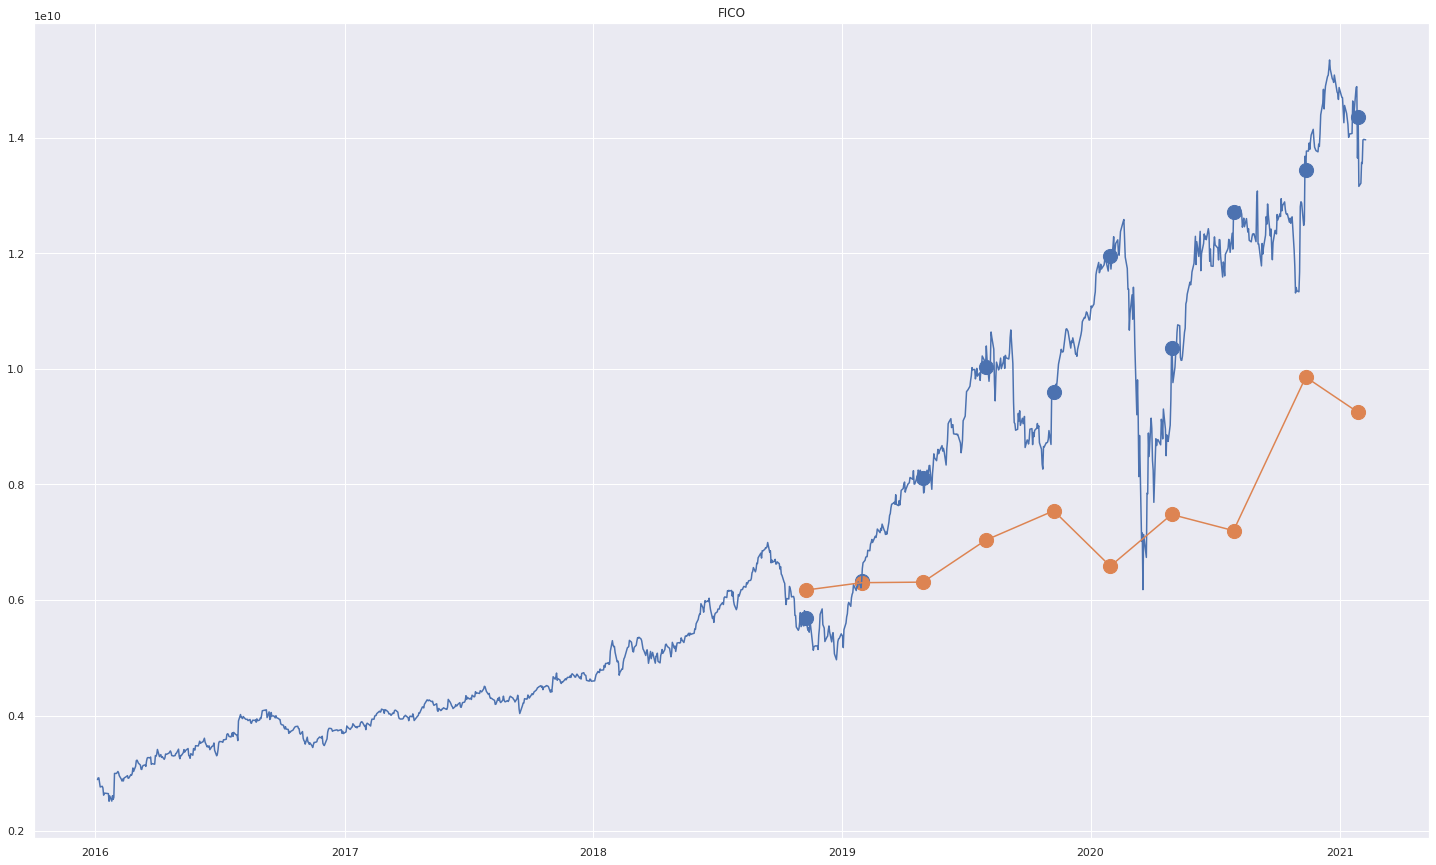

In [101]:
ticker = 'FICO'

daily_df = load_cf1_df('{}/cf1/daily/{}.json'.format(config['data_path'], ticker))
X_curr = X[X['ticker']==ticker]
pred_curr = pred_df[pred_df['ticker']==ticker]


plt.figure(figsize=(25,15))
plt.title(ticker)
plt.plot([np.datetime64(x) for x in daily_df['date']][::-1], daily_df['marketcap'].values[::-1] * 1e6)
plt.scatter([np.datetime64(x) for x in X_curr['date']][::-1], X_curr['marketcap'].values[::-1], s=200)
plt.scatter([np.datetime64(x) for x in pred_curr['date']][::-1], pred_curr['pred_marketcap'].values[::-1], s=200)
plt.plot([np.datetime64(x) for x in pred_curr['date']][::-1], pred_curr['pred_marketcap'].values[::-1])
plt.show()

In [33]:
X_curr

,ticker,date,marketcap,quarter2_revenue_mean,quarter2_revenue_median,quarter2_revenue_max,quarter2_revenue_min,quarter2_revenue_std,quarter2_revenue_diff_mean,quarter2_revenue_diff_median,...,quarter10_netinccmn_max,quarter10_netinccmn_min,quarter10_netinccmn_std,quarter10_netinccmn_diff_mean,quarter10_netinccmn_diff_median,quarter10_netinccmn_diff_max,quarter10_netinccmn_diff_min,quarter10_netinccmn_diff_std,sector,sicindustry
3423,YNDX,2020-10-28,1.656677e+12,3.807098e+12,3.807098e+12,NaN,NaN,8.013669e+11,1.602734e+12,1.602734e+12,...,NaN,NaN,5.011957e+11,1.514051e+11,1.008059e+10,NaN,NaN,6.986410e+11,10,254
3424,YNDX,2020-07-28,1.448477e+12,3.120643e+12,3.120643e+12,NaN,NaN,1.149122e+11,-2.298243e+11,-2.298243e+11,...,NaN,NaN,2.020228e+11,-7.136757e+10,-1.483755e+10,NaN,NaN,2.566932e+11,10,254
3425,YNDX,2020-06-23,1.105280e+12,3.378903e+12,3.378903e+12,NaN,NaN,1.433473e+11,-2.866946e+11,-2.866946e+11,...,NaN,NaN,1.293069e+11,7.514117e+09,1.008059e+10,NaN,NaN,1.592517e+11,10,254
3426,YNDX,2020-04-28,9.230385e+11,3.679047e+12,3.679047e+12,NaN,NaN,1.567965e+11,-3.135930e+11,-3.135930e+11,...,NaN,NaN,5.730918e+11,-1.887750e+11,1.008059e+10,NaN,NaN,5.920986e+11,10,254
3427,YNDX,2020-04-02,7.981452e+11,3.561854e+12,3.561854e+12,NaN,NaN,2.739887e+11,5.479773e+11,5.479773e+11,...,NaN,NaN,5.807675e+11,-8.474411e+09,1.008059e+10,NaN,NaN,9.009172e+11,10,254
3428,YNDX,2020-02-14,9.769911e+11,3.087029e+12,3.087029e+12,NaN,NaN,2.008370e+11,4.016740e+11,4.016740e+11,...,NaN,NaN,5.739550e+11,-1.566972e+10,-1.483755e+10,NaN,NaN,9.009989e+11,10,254
3429,YNDX,2019-10-25,6.796626e+11,2.755543e+12,2.755543e+12,NaN,NaN,1.306490e+11,2.612981e+11,2.612981e+11,...,NaN,NaN,5.661821e+11,1.101693e+10,2.644684e+09,NaN,NaN,8.975827e+11,10,254
3430,YNDX,2019-07-26,7.677623e+11,2.501806e+12,2.501806e+12,NaN,NaN,1.230872e+11,2.461744e+11,2.461744e+11,...,NaN,NaN,5.777773e+11,2.033205e+10,2.644684e+09,NaN,NaN,8.985094e+11,10,254
3431,YNDX,2019-04-25,7.712403e+11,2.430218e+12,2.430218e+12,NaN,NaN,5.149891e+10,-1.029978e+11,-1.029978e+11,...,NaN,NaN,5.787102e+11,1.733477e+09,-1.483755e+10,NaN,NaN,9.002568e+11,10,254
3432,YNDX,2019-04-19,7.747176e+11,2.529276e+12,2.529276e+12,NaN,NaN,4.755902e+10,-9.511803e+10,-9.511803e+10,...,NaN,NaN,5.873834e+11,3.777556e+10,2.644684e+09,NaN,NaN,8.994563e+11,10,254


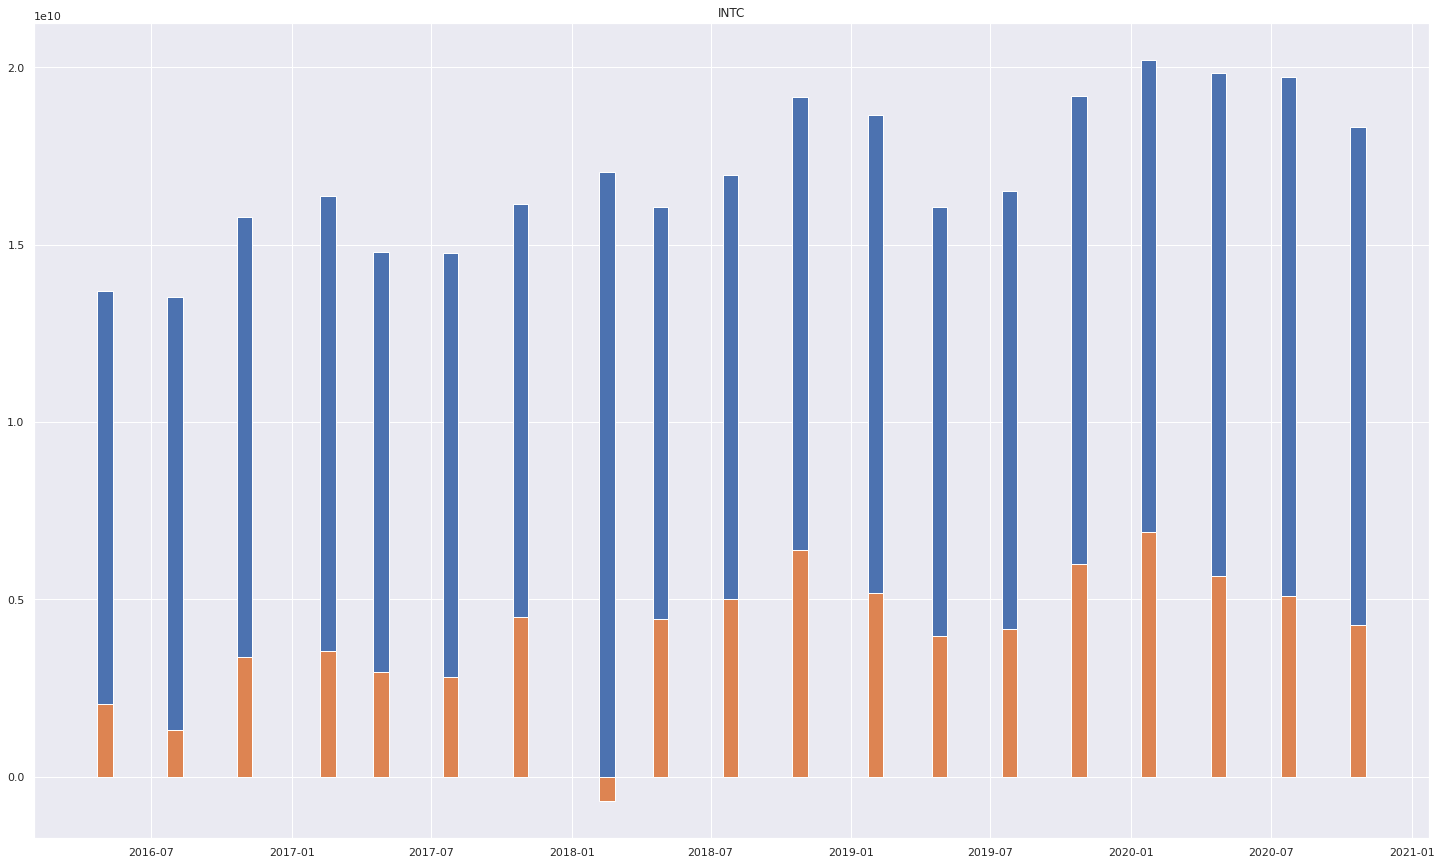

In [38]:
plt.figure(figsize=(25,15))
plt.title(ticker)
quarterely_df = pd.DataFrame(load_quarterly_data_cf1(ticker, config))
plt.bar([np.datetime64(x) for x in quarterely_df['date']][::-1], quarterely_df['revenue'].values[::-1], 20)
plt.bar([np.datetime64(x) for x in quarterely_df['date']][::-1], quarterely_df['netinc'].values[::-1], 20)

plt.show()